In [61]:
# Bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.sparse import csr_matrix
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import contractions
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [62]:
!pip install contractions

In [63]:
# Configurar palabras vacías (stopwords)
stop_words = set(stopwords.words('english')) - {"not", "no", "never"}
lemmatizer = WordNetLemmatizer()

# Preprocesamiento de texto
def preprocess_text(text):
    text = contractions.fix(text)  # Expandir contracciones
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Eliminar URLs
    text = re.sub(r'<.*?>', '', text)  # Eliminar HTML
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = re.sub(r'\d+', '', text)  # Eliminar números
    tokens = word_tokenize(text.lower())  # Convertir a minúsculas y tokenizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [64]:
# Cargar el dataset
#data = pd.read_csv("emotions_dataset.csv")

In [65]:
# Cargar dataset desde drive
from google.colab import drive
drive.mount('/content/drive')

# Ruta completa al archivo
file_path = '/content/drive/MyDrive/IA/emotions_dataset.csv'

# Cargar el archivo CSV
data = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
# Análisis inicial
print(data.head())  # Vista rápida de los datos
print(data['label'].value_counts())  # Distribución de etiquetas

print(f'The Shape Of Data Is : {data.shape}') # Forma de los datos
data.isnull().sum()  # Verificar valores nulos

data.duplicated().sum()  # Verificar valores duplicados


   Unnamed: 0                                               text  label
0           0      i just feel really helpless and heavy hearted      4
1           1  ive enjoyed being able to slouch about relax a...      0
2           2  i gave up my internship with the dmrg and am f...      4
3           3                         i dont know i feel so lost      0
4           4  i am a kindergarten teacher and i am thoroughl...      4
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64
The Shape Of Data Is : (416809, 3)


0

In [69]:
# Renombrar columnas
data.rename(columns={"text": "Texto", "label": "Emocion"}, inplace=True)

# Borrar columna de index si existe
if 'Unnamed: 0' in data.columns:
    data.drop('Unnamed: 0', axis=1, inplace=True)

data.head()  # Vista rápida de los datos

data_aux = data.copy()  # Copia de seguridad

# Renombrar las emociones
data_aux['Emocion'] = data_aux['Emocion'].replace({0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'})


<ipython-input-70-066a537c0f5d>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=ax[1], palette=palette)


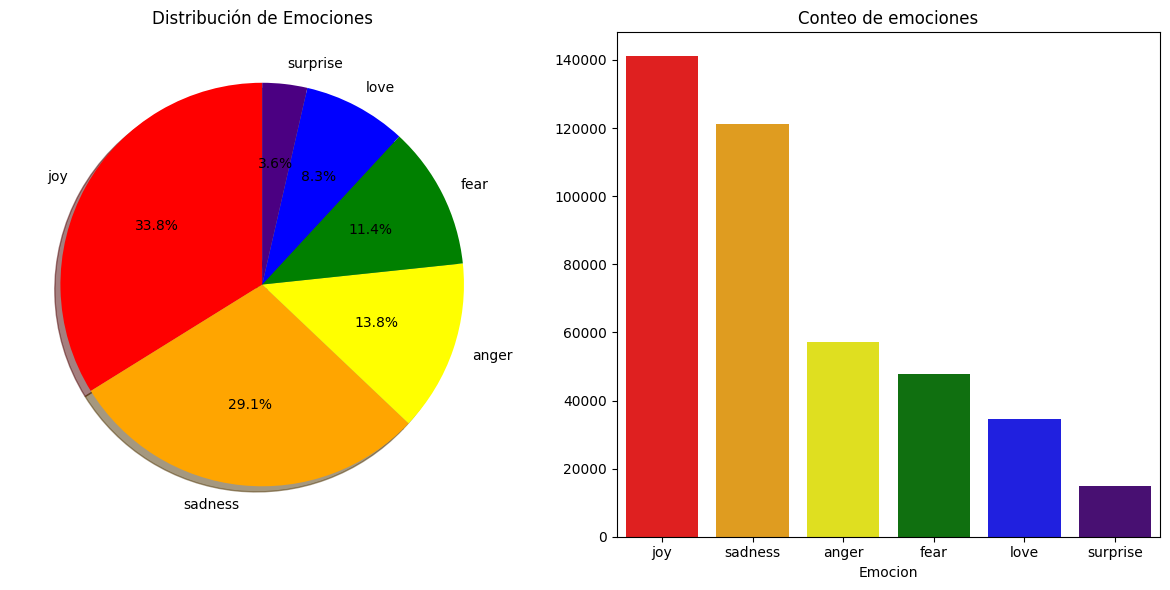

In [70]:
# Analisis Grafico
count = data_aux['Emocion'].value_counts()

# Crear columna con dos subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Grafico de barras
palette = ["#FF0000", "#FFA500", "#FFFF00", "#008000", "#0000FF", "#4B0082"]
sns.set_palette(palette)
ax[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=90, shadow=True)
ax[0].set_title('Distribución de Emociones')

sns.barplot(x=count.index, y=count.values, ax=ax[1], palette=palette)
ax[1].set_title('Conteo de emociones')

plt.tight_layout()
plt.show()

In [71]:
# Separa el data set para visualizar las emociones
sadness = data_aux[data_aux['Emocion'] == 'sadness']
joy = data_aux[data_aux['Emocion'] == 'joy']
love = data_aux[data_aux['Emocion'] == 'love']
anger = data_aux[data_aux['Emocion'] == 'anger']
fear = data_aux[data_aux['Emocion'] == 'fear']
surprise = data_aux[data_aux['Emocion'] == 'surprise']

In [72]:
# Crear wordclouds
def wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(' '.join(data['Texto']))
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(title)
    plt.tight_layout()
    plt.show()

wordcloud(sadness, 'Sadness')
wordcloud(joy, 'Joy')
wordcloud(love, 'Love')
wordcloud(anger, 'Anger')
wordcloud(fear, 'Fear')
wordcloud(surprise, 'Surprise')

KeyboardInterrupt: 

In [74]:
# Aplicar preprocesamiento al dataset
data['clean_text'] = data['Texto'].apply(preprocess_text)

# Mostrar resultados preprocesados
print(data.head())

                                               Texto  Emocion  \
0      i just feel really helpless and heavy hearted        4   
1  ive enjoyed being able to slouch about relax a...        0   
2  i gave up my internship with the dmrg and am f...        4   
3                         i dont know i feel so lost        0   
4  i am a kindergarten teacher and i am thoroughl...        4   

                                          clean_text  
0                 feel really helpless heavy hearted  
1  enjoyed able slouch relax unwind frankly neede...  
2            gave internship dmrg feeling distraught  
3                                 not know feel lost  
4  kindergarten teacher thoroughly weary job take...  


In [75]:
# División de datos
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['Emocion'], test_size=0.2, random_state=42)

# Vectorización usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = csr_matrix(vectorizer.fit_transform(X_train))
X_test_vec = csr_matrix(vectorizer.transform(X_test))

# One-hot encoding de etiquetas
num_classes = len(np.unique(y_train))
y_train_one = np.eye(num_classes)[y_train]

In [76]:
# Definir funciones de activación y pérdida
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def categorical_cross_entropy(y, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(np.sum(y * np.log(y_pred), axis=1))


In [82]:
# Entrenamiento con mini-batch gradient descent
def train_gradient_descen(X, y, learning_rate, epochs, batch_size=128, tol=1e-6, optimizer="adam"):
    weights = np.random.randn(X.shape[1], y.shape[1]) * 0.01  # Pesos inicializados aleatoriamente
    bias = np.zeros((y.shape[1],))  # Sesgo inicial
    losses = []

    # Inicialización de Adam
    m_w, v_w = np.zeros_like(weights), np.zeros_like(weights)
    m_b, v_b = np.zeros_like(bias), np.zeros_like(bias)
    beta1, beta2, eps = 0.9, 0.999, 1e-8
    t = 0

    for epoch in range(epochs):
        for i in range(0, X.shape[0], batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            # Predicción
            linear_model = X_batch.dot(weights) + bias
            y_pred = softmax(linear_model)

            # Calcular gradientes
            error = y_pred - y_batch
            gradients_w = X_batch.T.dot(error) / batch_size
            gradients_b = np.mean(error, axis=0)

            # Optimización con Adam
            if optimizer == "adam":
                t += 1
                m_w = beta1 * m_w + (1 - beta1) * gradients_w
                v_w = beta2 * v_w + (1 - beta2) * (gradients_w ** 2)
                m_b = beta1 * m_b + (1 - beta1) * gradients_b
                v_b = beta2 * v_b + (1 - beta2) * (gradients_b ** 2)

                m_w_hat = m_w / (1 - beta1 ** t)
                v_w_hat = v_w / (1 - beta2 ** t)
                m_b_hat = m_b / (1 - beta1 ** t)
                v_b_hat = v_b / (1 - beta2 ** t)

                weights -= learning_rate * m_w_hat / (np.sqrt(v_w_hat) + eps)
                bias -= learning_rate * m_b_hat / (np.sqrt(v_b_hat) + eps)
            else:  # SGD
                weights -= learning_rate * gradients_w
                bias -= learning_rate * gradients_b

        # Calcular pérdida
        loss = categorical_cross_entropy(y, softmax(X.dot(weights) + bias))
        losses.append(loss)

        # Early Stopping
        if epoch > 1 and abs(losses[-1] - losses[-2]) < tol:
            print(f"Entrenamiento detenido en la época {epoch}, pérdida: {loss}")
            break

        if epoch % 10 == 0:
            print(f"Época {epoch}, Pérdida: {loss}")

    return weights, bias, losses


In [78]:
# Predicción
def predict(X, weights, bias):
    linear_model = X.dot(weights) + bias
    y_pred = softmax(linear_model)
    return np.argmax(y_pred, axis=1)

In [83]:
# Entrenar el modelo
weights, bias, losses = train_gradient_descen(
    X_train_vec, y_train_one, learning_rate=0.01, epochs=300, batch_size=128, tol=1e-4, optimizer="adam"
)

# Evaluar el modelo
y_pred = predict(X_test_vec, weights, bias)
print("Precisión:", accuracy_score(y_test, y_pred))
print("Informe de clasificación:\n", classification_report(y_test, y_pred))

Época 0, Pérdida: 0.2568277071885388
Época 10, Pérdida: 0.1826984609055522
Entrenamiento detenido en la época 20, pérdida: 0.1805993101803664
Precisión: 0.8928048751229577
Informe de clasificación:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     24201
           1       0.91      0.92      0.92     28164
           2       0.78      0.77      0.78      6929
           3       0.90      0.90      0.90     11441
           4       0.83      0.84      0.84      9594
           5       0.73      0.66      0.69      3033

    accuracy                           0.89     83362
   macro avg       0.85      0.84      0.84     83362
weighted avg       0.89      0.89      0.89     83362



In [86]:
# Función para preprocesar una frase de prueba
def preprocess_input_text(text):
    text = contractions.fix(text)  # Expandir contracciones
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Eliminar URLs
    text = re.sub(r'<.*?>', '', text)  # Eliminar HTML
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar puntuación
    text = re.sub(r'\d+', '', text)  # Eliminar números
    tokens = word_tokenize(text.lower())  # Convertir a minúsculas y tokenizar
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)


In [88]:
# Definir las etiquetas de las clases
class_labels = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

test_sentences = [
    "I feel happy about my promotion, but I am also nervous about the new responsibilities.",
    "I don't know how to feel about this situation.",
    "Sure, I’m happy for you, I guess.",
    "I was angry when it happened, but now I just feel sad.",
    "Wow, just what I needed today, another challenge.",
    "This is everything I ever wanted, but why do I feel so unsettled?",
    "I worked so hard for this moment, and now that it's here, I feel empty."
]

for sentence in test_sentences:
    processed_text = preprocess_input_text(sentence)
    test_vector = vectorizer.transform([processed_text])
    predicted_class_index = predict(test_vector, weights, bias)
    predicted_class = class_labels[predicted_class_index[0]]
    print(f"Frase: '{sentence}' → Emoción predicha: {predicted_class}")


Frase: 'I feel happy about my promotion, but I am also nervous about the new responsibilities.' → Emoción predicha: fear
Frase: 'I don't know how to feel about this situation.' → Emoción predicha: joy
Frase: 'Sure, I’m happy for you, I guess.' → Emoción predicha: joy
Frase: 'I was angry when it happened, but now I just feel sad.' → Emoción predicha: anger
Frase: 'Wow, just what I needed today, another challenge.' → Emoción predicha: sadness
Frase: 'This is everything I ever wanted, but why do I feel so unsettled?' → Emoción predicha: joy
Frase: 'I worked so hard for this moment, and now that it's here, I feel empty.' → Emoción predicha: sadness
